In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
from scipy.spatial.distance import cosine, euclidean
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import cv2
from PIL import Image
from evaluation.neuroprobe.config import ROOT_DIR, SAMPLING_RATE
from subject.braintreebank import BrainTreebankSubject
import pandas as pd
import math
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

SUBJECT_TRIAL_TO_MOVIE = {
    (1,0): 'fantastic-mr-fox.mp4',
    (1,1): 'the-martian.mp4',
    (1,2): 'thor-ragnarok.mp4',
    (2,0): 'venom.mp4',
    (2,1): 'spider-man-3-homecoming.mp4',
    (2,2): 'guardians-of-the-galaxy.mp4',
    (2,3): 'guardians-of-the-galaxy-2.mp4',
    (2,4): 'avengers-infinity-war.mp4',
    (2,5): 'black-panther.mp4',
    (2,6): 'aquaman.mp4',
    (3,0): 'cars-2.mp4',
    (3,1): 'lotr-1.mp4',
    (3,2): 'lotr-2.mp4',
    (4,0): 'shrek-the-third.mp4',
    (4,1): 'megamind.mp4',
    (4,2): 'incredibles.mp4',
    (5,0): 'fantastic-mr-fox.mp4',
    (6,0): 'megamind.mp4',
    (6,1): 'toy-story.mp4',
    (6,2): 'coraline.mp4',
    (7,0): 'cars-2.mp4',
    (7,1): 'megamind.mp4',
    (8,0): 'sesame-street-episode-3990.mp4',
    (9,0): 'ant-man.mp4',
    (10,0): 'cars-2.mp4',
    (10,1): 'spider-man-far-from-home.mp4',
}

CLIP_DIR = "/om2/data/public/braintreebank_movies_clip_preprocessed_2/"
MOVIES_DIR = "/om2/data/public/braintreebank_movies/"

In [2]:
def extract_frame_at_time(video_path, timestamp):
    """
    Extract a frame from video at a specific timestamp.
    
    Args:
        video_path (str): Path to the video file
        timestamp (float): Timestamp in seconds
    Returns:
        PIL.Image: The extracted frame as PIL Image
    """
    cap = cv2.VideoCapture(video_path)
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_number = int(timestamp * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"Warning: Could not extract frame at timestamp {timestamp}")
        return None
    
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)
    
    return pil_image


def obtain_neural_data_index(sub_id, trial_id, movie_times):
    # Data frames column IDs
    start_col, end_col = 'start', 'end'
    trig_time_col, trig_idx_col, est_idx_col, est_end_idx_col = 'movie_time', 'index', 'est_idx', 'est_end_idx'

    # Path to trigger times csv file
    trigger_times_file = os.path.join(ROOT_DIR, f'subject_timings/sub_{sub_id}_trial{trial_id:03}_timings.csv')

    trigs_df = pd.read_csv(trigger_times_file)
    # display(trigs_df.head())

    last_t = trigs_df[trig_time_col].iloc[-1]
    assert np.all(movie_times < last_t), "Movie times must be less than the last trigger time"
    
    # Vectorized nearest trigger finding
    start_indices = np.searchsorted(trigs_df[trig_time_col].values, movie_times)
    start_indices = np.maximum(start_indices, 0) # handle the edge case where movie starts right at the word
    
    # Vectorized sample index calculation
    return np.round(
        trigs_df.loc[start_indices, trig_idx_col].values + 
        (movie_times - trigs_df.loc[start_indices, trig_time_col].values) * SAMPLING_RATE
    ).astype(int)

def get_neural_data_at_index(subject_id, trial_id, electrode, start, end):
    subject = BrainTreebankSubject(subject_id, cache=False)
    neural_data = subject.get_electrode_data(electrode,trial_id,window_from=start, window_to=end)
    return neural_data

In [3]:
def get_movie_data(movie):
    clip_features_path = os.path.join(CLIP_DIR, movie.replace('.mp4', '_clip_features.npy'))
    timestamps_path = os.path.join(CLIP_DIR, movie.replace('.mp4', '_timestamps.npy'))
    movie_path = os.path.join(MOVIES_DIR, movie)

    clip_features = np.load(clip_features_path)  # shape: (num_samples, feature_dim)
    timestamps = np.load(timestamps_path)
    return clip_features, timestamps, movie_path

def get_subject_trial_from_movie(movie):
    subject_trial_list = []
    for subject_trial, movie_name in SUBJECT_TRIAL_TO_MOVIE.items():
        if movie_name == movie:
            subject_trial_list.append(subject_trial)
    return subject_trial_list

def get_unique_electrodes(electrode_locations):
    unique_electrodes = {}
    seen_values = set()
    
    for key, value in electrode_locations.items():
        if value not in seen_values:
            unique_electrodes[key] = value
            seen_values.add(value)
    
    return list(unique_electrodes.keys())

In [19]:
movie = 'ant-man.mp4'
clip_features, timestamps, movie_path = get_movie_data(movie)

subject_trial_list = get_subject_trial_from_movie(movie)
subject_id, trial_id = subject_trial_list[0]
subject = BrainTreebankSubject(subject_id, cache=False)
electrode_locations = {electrode_label: subject.get_electrode_metadata(electrode_label)['DesikanKilliany'] for electrode_label in subject.get_electrode_labels()}
unique_electrodes = electrode_locations.keys()

trigger_times_file = os.path.join(ROOT_DIR, f'subject_timings/sub_{subject_id}_trial{trial_id:03}_timings.csv')
trigs_df = pd.read_csv(trigger_times_file)
last_trigger_time = trigs_df['movie_time'].iloc[-1]
safe_end_timestamp = min(timestamps[-2], last_trigger_time - 1.0)  # 1 second buffer

sampled_times = np.arange(0, safe_end_timestamp, 10.0)
sampled_indices = obtain_neural_data_index(subject_id, trial_id, sampled_times)

# start_idx = obtain_neural_data_index(subject_id, trial_id, np.array([0])).item()
# end_idx = obtain_neural_data_index(subject_id, trial_id, np.array([safe_end_timestamp])).item()
# neural_data = subject.get_all_electrode_data(trial_id, window_from=start_idx, window_to=end_idx)

# neural_data.shape

sampled_indices

array([ 372476,  382966,  393184,  403335,  413611,  423928,  434146,
        444297,  454571,  464890,  475113,  485257,  495478,  505852,
        516072,  526220,  536441,  546811,  557031,  567183,  577404,
        587776,  597994,  608146,  618365,  628738,  638956,  649175,
        659328,  669613,  679919,  690154,  700289,  710563,  720880,
        731102,  741249,  751488,  761844,  772081,  782203,  792450,
        802806,  813025,  823177,  833414,  843770,  854004,  864140,
        874375,  884732,  894952,  905186,  915338,  925592,  935913,
        946146,  956282,  966553,  976892,  987110,  997262, 1007479,
       1017837, 1028073, 1038221, 1048442, 1058800, 1069021, 1079169,
       1089403, 1099764, 1109981, 1120130, 1130350, 1140722, 1150960,
       1161180, 1171316, 1181600, 1191904, 1202129, 1212279, 1222563,
       1232883, 1243089, 1253234, 1263474, 1273829, 1284065, 1294199,
       1304451, 1314789, 1325028, 1335159, 1345396, 1355752, 1365987,
       1376122, 1386

In [20]:
# Find the indices in `timestamps` that are closest to each value in `sampled_times`
timestamp_indices = np.searchsorted(timestamps, sampled_times, side="left")
timestamp_indices

array([     0,    240,    480,    720,    960,   1199,   1439,   1679,
         1919,   2158,   2398,   2638,   2878,   3117,   3357,   3597,
         3837,   4076,   4316,   4556,   4796,   5035,   5275,   5515,
         5755,   5994,   6234,   6474,   6714,   6954,   7193,   7433,
         7673,   7913,   8152,   8392,   8632,   8872,   9111,   9351,
         9591,   9831,  10070,  10310,  10550,  10790,  11029,  11269,
        11509,  11749,  11988,  12228,  12468,  12708,  12948,  13187,
        13427,  13667,  13907,  14146,  14386,  14626,  14866,  15105,
        15345,  15585,  15825,  16064,  16304,  16544,  16784,  17023,
        17263,  17503,  17743,  17982,  18222,  18462,  18702,  18942,
        19181,  19421,  19661,  19901,  20140,  20380,  20620,  20860,
        21099,  21339,  21579,  21819,  22058,  22298,  22538,  22778,
        23017,  23257,  23497,  23737,  23976,  24216,  24456,  24696,
        24936,  25175,  25415,  25655,  25895,  26134,  26374,  26614,
      

In [ ]:
# Use the existing build_clip_neural_dataset function to handle variable window lengths properly
electrode_label = list(unique_electrodes)[0]  # pick the first unique electrode
X, y, valid_sampled_times = build_clip_neural_dataset(
    subject, trial_id, electrode_label, clip_features, sampled_times, sampled_indices
)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("valid_sampled_times shape:", valid_sampled_times.shape)

# Split into train and test sets (e.g., 80/20 split)
X_train, X_test, y_train, y_test, times_train, times_test = train_test_split(
    X, y, valid_sampled_times, test_size=0.2, random_state=42
)

print("Training set shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

In [64]:
window_ms = 250

electrode_label = list(unique_electrodes)[0]  
windowed_neural_data = []

for t in tqdm(sampled_times):
    window_start = t - window_ms / 1000
    window_end = t + window_ms / 1000

    idx_start = obtain_neural_data_index(subject_id, trial_id, np.array([window_start])).item()
    # idx_end = obtain_neural_data_index(subject_id, trial_id, np.array([window_end])).item() + 1  # +1 for inclusive window
    idx_end = int(idx_start + 0.75 * 2048)

    data = subject.get_electrode_data(electrode_label, trial_id, window_from=idx_start, window_to=idx_end)
    windowed_neural_data.append(data.cpu().numpy() if hasattr(data, "cpu") else data)

# Pad shorter windows to match the longest one
# max_length = max(len(w) for w in windowed_neural_data)
# padded_data = [np.pad(w, (0, max_length - len(w)), mode='constant') for w in windowed_neural_data]
y = np.stack(windowed_neural_data)


X = clip_features[timestamp_indices]

# Split into train and test sets (e.g., 80/20 split)
X_train, X_test, y_train, y_test, times_train, times_test = train_test_split(
    X, y, sampled_times, test_size=0.2, random_state=42
)

  0%|▉                                                                                                                                                                                                                                                                                                          | 2/647 [00:00<00:35, 18.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 647/647 [00:29<00:00, 22.13it/s]


In [66]:
X.shape

(647, 512)

In [73]:
y.shape

(647, 1536)

In [74]:
y_copy = y.copy()

# AVERAGE
y_avg = np.mean(y_copy, axis=1)
y_avg.shape

X_train, X_test, y_train, y_test, times_train, times_test = train_test_split(
    X, y_avg, sampled_times, test_size=0.2, random_state=42
)

In [79]:
from model.electrode_embedding import ElectrodeEmbedding_Learned, ElectrodeEmbedding_NoisyCoordinate, ElectrodeEmbedding_Learned_CoordinateInit, ElectrodeEmbedding_Zero
from model.preprocessing.laplacian_rereferencing import laplacian_rereference_batch
from training_setup.training_config import log
import torch
from training_setup.training_setup import TrainingSetup
from model.BFModule import BFModule
from model.transformer_implementation import Transformer
import torch.nn as nn

class SpectrogramPreprocessor(BFModule):
    def __init__(self, output_dim=-1, max_frequency=200):
        super(SpectrogramPreprocessor, self).__init__()
        self.max_frequency = max_frequency
        self.output_dim = output_dim

        assert self.max_frequency == 200, "Max frequency must be 200"
        self.max_frequency_bin = 40 # XXX hardcoded max frequency bin
        
        # Transform FFT output to match expected output dimension
        self.output_transform = nn.Identity() if self.output_dim == -1 else nn.Linear(self.max_frequency_bin, self.output_dim)
    
    def forward(self, batch):
        # batch['data'] is of shape (batch_size, n_electrodes, n_samples)
        # batch['metadata'] is a dictionary containing metadata like the subject identifier and trial id, sampling rate, etc.
        batch_size, n_electrodes = batch['data'].shape[:2]
        
        # Reshape for STFT
        x = batch['data'].reshape(batch_size * n_electrodes, -1)
        x = x.to(dtype=torch.float32)  # Convert to float32 for STFT
        
        # STFT parameters
        nperseg = 400
        noverlap = 350
        window = torch.hann_window(nperseg, device=x.device)
        hop_length = nperseg - noverlap
        
        # Compute STFT
        x = torch.stft(x,
                      n_fft=nperseg, 
                      hop_length=hop_length,
                      win_length=nperseg,
                      window=window,
                      return_complex=True,
                      normalized=False,
                      center=True)
        
        # Take magnitude
        x = torch.abs(x)
        
        # Pad or trim to max_frequency dimension
        if x.shape[1] < self.max_frequency_bin:
            x = torch.nn.functional.pad(x, (0, 0, 0, self.max_frequency_bin - x.shape[1]))
        else:
            x = x[:, :self.max_frequency_bin]
            
        # Reshape back
        _, n_freqs, n_times = x.shape
        x = x.reshape(batch_size, n_electrodes, n_freqs, n_times)
        x = x.transpose(2, 3) # (batch_size, n_electrodes, n_timebins, n_freqs)
        
        # Z-score normalization
        x = x - x.mean(dim=[0, 2], keepdim=True)
        x = x / (x.std(dim=[0, 2], keepdim=True) + 1e-5)

        # Transform to match expected output dimension
        # x = self.output_transform(x)  # shape: (batch_size, n_electrodes, n_timebins, output_dim)

        sr = batch['metadata'].get('sampling_rate', 2048)

        # Frequency bins (as in torch.stft)
        freq_bins = torch.fft.rfftfreq(nperseg, d=1/sr)  # length: nperseg//2+1
        # Only keep up to max_frequency_bin
        freq_bins = freq_bins[:self.max_frequency_bin]  # shape: (max_frequency_bin,)

        # Time bins (center of each window)
        n_timebins = x.shape[2]  # after transpose, x.shape = (batch, n_electrodes, n_timebins, n_freqs)
        # torch.stft centers windows by default (center=True)
        # The time for each bin is: (hop_length * i) / sr, for i in 0..n_timebins-1
        time_bins = torch.arange(n_timebins, device=x.device) * hop_length / sr  # shape: (n_timebins,)
        
        return x.to(dtype=batch['data'].dtype), freq_bins, time_bins

In [75]:
y_copy.shape

(647, 1536)

In [80]:

y_tensor = torch.tensor(y_copy)
y_tensor = y_tensor.reshape(647, 1, 1536)

spec_preproc = SpectrogramPreprocessor()
y_spectrogram, freq_bins, time_bins = spec_preproc({'data': y_tensor, 'metadata': {}})  # shape: (batch_size, n_electrodes, n_timebins, n_freqs)

freq_bin_edges = {
    'delta': (0, 4),    # 0-20 Hz (bins 0-3)
    'theta': (4, 8),    # 20-40 Hz (bins 4-7)
    'alpha': (8, 12),   # 40-60 Hz (bins 8-11)
    'beta': (12, 30),   # 60-150 Hz (bins 12-29)
    'gamma': (30, 40),  # 150-200 Hz (bins 30-39)
}

y_band_dict = {}
for band, (start, end) in freq_bin_edges.items():
    # Average across the frequency bins for each band
    y_band_dict[band] = y_spectrogram[..., start:end].mean(dim=-1)  # shape: (batch_size, n_electrodes, n_timebins)

# Now y_band_dict contains the neural data averaged in each frequency band
# Example: y_band_dict['alpha'] is the alpha band neural activity
y_band_dict['alpha'].shape

torch.Size([647, 1, 31])

In [81]:
y_spectrogram.shape

torch.Size([647, 1, 31, 40])

In [82]:
freq_bins

tensor([  0.0000,   5.1200,  10.2400,  15.3600,  20.4800,  25.6000,  30.7200,
         35.8400,  40.9600,  46.0800,  51.2000,  56.3200,  61.4400,  66.5600,
         71.6800,  76.8000,  81.9200,  87.0400,  92.1600,  97.2800, 102.4000,
        107.5200, 112.6400, 117.7600, 122.8800, 128.0000, 133.1200, 138.2400,
        143.3600, 148.4800, 153.6000, 158.7200, 163.8400, 168.9600, 174.0800,
        179.2000, 184.3200, 189.4400, 194.5600, 199.6800])

In [83]:
time_bins

tensor([0.0000, 0.0244, 0.0488, 0.0732, 0.0977, 0.1221, 0.1465, 0.1709, 0.1953,
        0.2197, 0.2441, 0.2686, 0.2930, 0.3174, 0.3418, 0.3662, 0.3906, 0.4150,
        0.4395, 0.4639, 0.4883, 0.5127, 0.5371, 0.5615, 0.5859, 0.6104, 0.6348,
        0.6592, 0.6836, 0.7080, 0.7324])

Timebin:   0%|                                                                                                                                                                                                                                                                                                           | 0/31 [00:00<?, ?it/s]

Timebin: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:48<00:00,  1.57s/it]


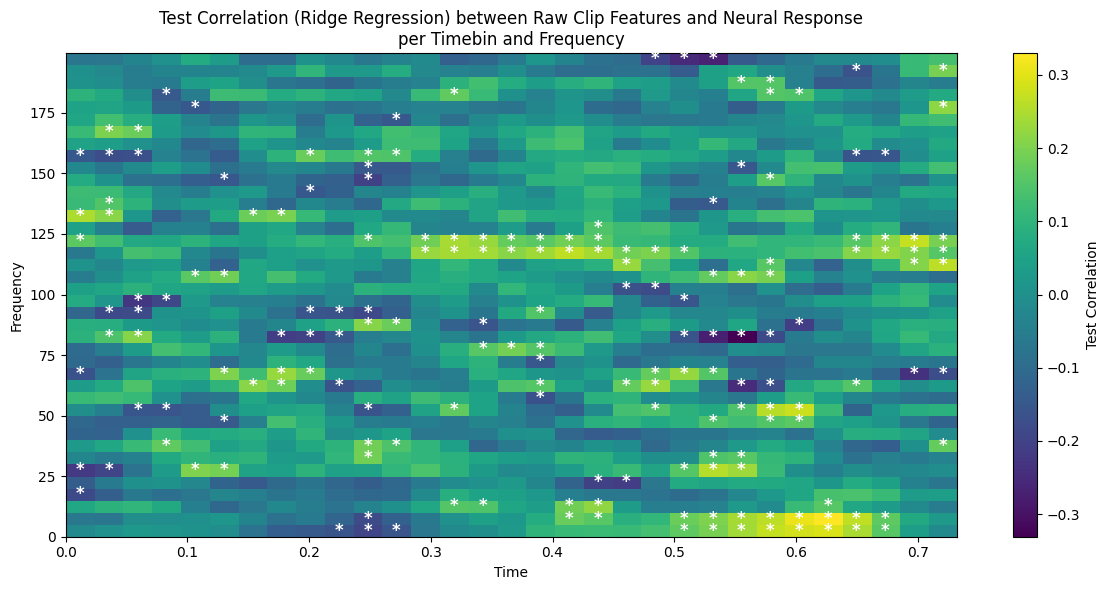

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from scipy.stats import pearsonr
from tqdm import tqdm

# y_spectrogram: (647, 1, 31, 40)
# X_clip: (647, 512) or similar, but we want to use the associated clip feature for each window
# We'll assume X_clip is (647, 512) and y_spectrogram is (647, 1, 31, 40)
# We'll use the mean of the clip features for each window as the regressor, or you can select a specific

n_timebins = y_spectrogram.shape[2]
n_freqs = y_spectrogram.shape[3]

correlation_matrix = np.zeros((n_freqs, n_timebins))

from sklearn.model_selection import train_test_split

# Prepare to store test correlations
test_correlation_matrix = np.zeros((n_freqs, n_timebins))
test_pval_matrix = np.zeros((n_freqs, n_timebins))

# Split data indices once for all (to keep test set consistent across all t,f)
n_samples = X.shape[0]
train_idx, test_idx = train_test_split(np.arange(n_samples), test_size=0.2, random_state=42)

for t in tqdm(range(n_timebins), desc="Timebin"):
    for f in range(n_freqs):
        # Get the neural response for all samples at this (t, f)
        y_vals = y_spectrogram[:, 0, t, f].cpu().numpy() if hasattr(y_spectrogram, 'cpu') else y_spectrogram[:, 0, t, f]
        # Split into train/test
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y_vals[train_idx], y_vals[test_idx]
        # Regression: X_clip_raw (n, 512) -> y_vals (n,)
        reg = Ridge(alpha=0.1)
        reg.fit(X_train, y_train)
        y_pred_test = reg.predict(X_test)
        corr, pval = pearsonr(y_test, y_pred_test)
        test_correlation_matrix[f, t] = corr
        test_pval_matrix[f, t] = pval

plt.figure(figsize=(12, 6))
im = plt.imshow(
    test_correlation_matrix,
    aspect='auto',
    origin='lower',
    cmap='viridis',
    extent=[
        time_bins[0].item() if hasattr(time_bins[0], 'item') else time_bins[0],
        time_bins[-1].item() if hasattr(time_bins[-1], 'item') else time_bins[-1],
        freq_bins[0].item() if hasattr(freq_bins[0], 'item') else freq_bins[0],
        freq_bins[-1].item() if hasattr(freq_bins[-1], 'item') else freq_bins[-1],
    ]
)

# Add stars for p < 0.1
# Find the (t, f) locations where pval < 0.1
star_y, star_x = np.where(test_pval_matrix < 0.1)
# Convert to axis coordinates
# x: time, y: freq
# To align the stars at the center of each image square, we need to compute the bin centers.
# Calculate bin edges and then centers for both time and frequency axes.
time_edges = np.linspace(
    time_bins[0].item() if hasattr(time_bins[0], 'item') else time_bins[0],
    time_bins[-1].item() if hasattr(time_bins[-1], 'item') else time_bins[-1],
    test_correlation_matrix.shape[1] + 1
)
freq_edges = np.linspace(
    freq_bins[0].item() if hasattr(freq_bins[0], 'item') else freq_bins[0],
    freq_bins[-1].item() if hasattr(freq_bins[-1], 'item') else freq_bins[-1],
    test_correlation_matrix.shape[0] + 1
)
time_centers = (time_edges[:-1] + time_edges[1:]) / 2
freq_centers = (freq_edges[:-1] + freq_edges[1:]) / 2

for y, x in zip(star_y, star_x):
    plt.text(
        time_centers[x], freq_centers[y], '*',
        color='white', fontsize=12, ha='center', va='center', fontweight='bold'
    )

plt.colorbar(im, label='Test Correlation')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Test Correlation (Ridge Regression) between Raw Clip Features and Neural Response\nper Timebin and Frequency')
plt.tight_layout()
plt.show()


Correlation: 0.1308, p-value: 1.3793e-01
Test R^2 score: 0.1308


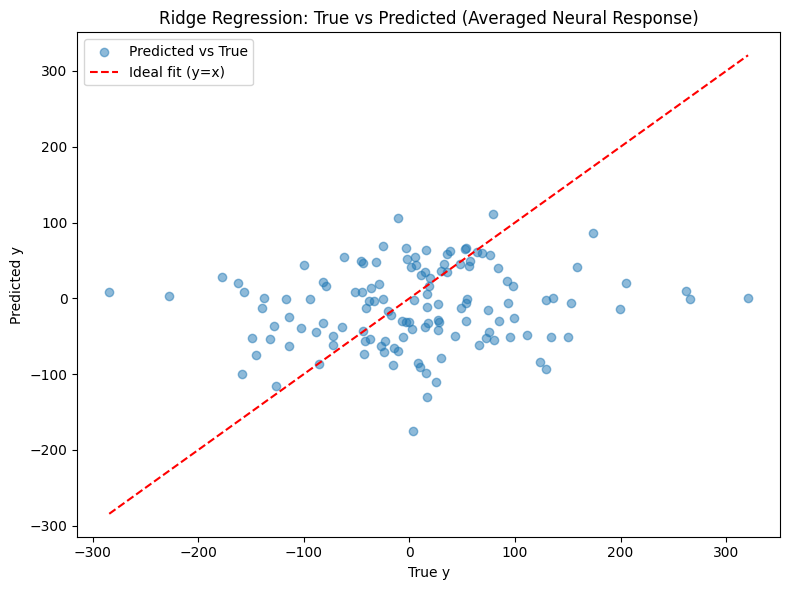

In [46]:

reg = Ridge(alpha=0.1)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
# r2 = r2_score(y_test, y_pred)

from scipy.stats import pearsonr

corr, pval = pearsonr(y_test, y_pred)
print(f"Correlation: {corr:.4f}, p-value: {pval:.4e}")

r2 = np.corrcoef(y_test, y_pred)[0, 1]
print(f"Test R^2 score: {r2:.4f}")


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs True')
# Plot regression line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal fit (y=x)')
plt.xlabel('True y')
plt.ylabel('Predicted y')
plt.title('Ridge Regression: True vs Predicted (Averaged Neural Response)')
plt.legend()
plt.tight_layout()
plt.show()


# n_examples = 5
# example_indices = np.random.choice(len(y_test), size=n_examples, replace=False)

# plt.figure(figsize=(15, 8))
# for i, idx in enumerate(example_indices):
#     plt.subplot(n_examples, 1, i + 1)
#     plt.plot(y_test[idx], label='True', color='black')
#     plt.plot(y_pred[idx], label='Predicted', color='red', linestyle='--')
#     plt.title(f"Test Example {i+1}")
#     if i == 0:
#         plt.legend()
#     plt.ylabel("Neural response")
# plt.xlabel("Time (sample in window)")
# plt.tight_layout()
# plt.show()



In [33]:
y_train_arr = np.array(y_train)
y_test_arr = np.array(y_test)
n_outputs = y_train_arr.shape[1]
gb_preds = np.zeros_like(y_test_arr)

# You can use scikit-learn's MultiOutputRegressor with HistGradientBoostingRegressor for parallelized fitting:
from sklearn.multioutput import MultiOutputRegressor

multi_gb = MultiOutputRegressor(HistGradientBoostingRegressor(max_iter=200), n_jobs=-1)
multi_gb.fit(X_train, y_train_arr)
multi_gb_preds = multi_gb.predict(X_test)
multi_gb_r2 = r2_score(y_test_arr, multi_gb_preds)
print(f"Test R^2 score (MultiOutputRegressor+HistGradientBoosting, mean over outputs): {multi_gb_r2:.4f}")


KeyboardInterrupt: 

In [ ]:
def build_clip_neural_dataset(
    subject, trial_id, 
    electrode_label, 
    clip_features, 
    sampled_times, 
    sampled_indices, 
    window_ms=250, 
    sampling_rate=1000
):
    """
    Build a dataset for a single electrode: 
    For each sampled time, use the CLIP features at that time to predict the neural response
    in a window of +/- window_ms (default 250ms) around that time.

    Args:
        subject: BrainTreebankSubject object
        trial_id: int
        electrode_label: str
        clip_features: np.ndarray, shape (n_samples, feature_dim)
        sampled_times: np.ndarray, shape (n_samples,)
        sampled_indices: np.ndarray, shape (n_samples,)
        window_ms: int, window size in ms before and after the time point
        sampling_rate: int, neural data sampling rate in Hz

    Returns:
        X: np.ndarray, shape (n_valid_samples, feature_dim)
        y: np.ndarray, shape (n_valid_samples, window_len)
        valid_sampled_times: np.ndarray, shape (n_valid_samples,)
    """
    # Calculate window in samples
    window_samples = int(window_ms * sampling_rate / 1000)
    window_len = 2 * window_samples + 1

    # Get all neural data for this electrode for the relevant range
    min_idx = sampled_indices[0] - window_samples
    max_idx = sampled_indices[-1] + window_samples + 1
    if min_idx < 0:
        min_idx = 0
    # Get neural data for this electrode
    neural_data = subject.get_electrode_data(electrode_label, trial_id, window_from=min_idx, window_to=max_idx)
    neural_data = neural_data.cpu().numpy() if hasattr(neural_data, "cpu") else neural_data

    X = []
    y = []
    valid_sampled_times = []
    for i, idx in enumerate(sampled_indices):
        # Compute window start and end relative to neural_data array
        rel_idx = idx - min_idx
        start = rel_idx - window_samples
        end = rel_idx + window_samples + 1
        # Check bounds
        if start < 0 or end > len(neural_data):
            continue
        X.append(clip_features[i])
        y.append(neural_data[start:end])
        valid_sampled_times.append(sampled_times[i])
    X = np.stack(X)
    y = np.stack(y)
    valid_sampled_times = np.array(valid_sampled_times)
    return X, y, valid_sampled_times

# Example usage for a single electrode:
electrode_label = list(unique_electrodes)[0]  # pick the first unique electrode
X, y, valid_sampled_times = build_clip_neural_dataset(
    subject, trial_id, electrode_label, clip_features, sampled_times, sampled_indices
)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("valid_sampled_times shape:", valid_sampled_times.shape)
